# Graph Neural Networks (GNNs)

## Quelle der Daten

https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database?resource=download (zuletzt aufgerufen 01/2024)
    
M.E.H. Chowdhury, T. Rahman, A. Khandakar, R. Mazhar, M.A. Kadir, Z.B. Mahbub, K.R. Islam, M.S. Khan, A. Iqbal, N. Al-Emadi, M.B.I. Reaz, M. T. Islam, “Can AI help in screening Viral and COVID-19 pneumonia?” IEEE Access, Vol. 8, 2020, pp. 132665 - 132676.

Rahman, T., Khandakar, A., Qiblawey, Y., Tahir, A., Kiranyaz, S., Kashem, S.B.A., Islam, M.T., Maadeed, S.A., Zughaier, S.M., Khan, M.S. and Chowdhury, M.E., 2020. Exploring the Effect of Image Enhancement Techniques on COVID-19 Detection using Chest X-ray Images.

## Installation der Bibliotheken

In [1]:
import os

import cv2

import matplotlib.pyplot as plt

import numpy as np

from sklearn.model_selection import train_test_split

import tensorflow as tf

from tensorflow.keras import Model, layers

from tensorflow.keras.layers import Dense, Input

import keras

## Einlesen und Präprozessierung der Daten

In [2]:
main_path = "C:\\Users\\Tim\\Desktop\\Buchprojekt KI Medizin\\Programmierung\\COVID-19_Radiography_Dataset_litee"
covid_dir = os.path.join(main_path, "covid_images")
normal_dir = os.path.join(main_path, "normal_images")

print("Anzahl Bilder mit COVID:", len(os.listdir(covid_dir)))
print("Anzahl normaler Bilder:", len(os.listdir(normal_dir)))

Anzahl Bilder mit COVID: 1000
Anzahl normaler Bilder: 1000


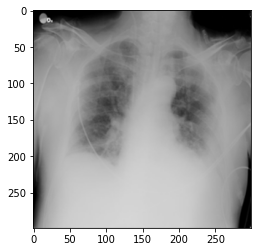

In [3]:
example_image = cv2.imread(os.path.join(covid_dir, "COVID-1.png"))

plt.imshow(example_image)

In [4]:
example_image.shape

(299, 299, 3)

In [5]:
def loadImages(dir, size, label):
  images = []
  labels = []

  for i in range(len(size)):
    img_path = dir + "/" + size[i]
    img = cv2.imread(img_path)
    img = img / 255.0
    img = cv2.resize(img, (100, 100))
    images.append(img)
    labels.append(label)

  images = np.asarray(images)

  return images, labels

In [6]:
covid_images, covid_labels = loadImages(covid_dir, os.listdir(covid_dir), 1)
len(covid_images), len(covid_labels)

normal_images, normal_labels = loadImages(normal_dir, os.listdir(normal_dir), 0)
len(normal_images), len(normal_labels)

(1000, 1000)

In [7]:
covid_images.shape

(1000, 100, 100, 3)

## Aufteilung der Daten

In [8]:
x = np.r_[covid_images, normal_images]

y = np.r_[covid_labels, normal_labels]

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.15)

## Umwandlung der Bilder in Graphen

In [10]:
def image_to_graph(image):
  h, w, c = image.shape

  node_indices = np.arange(h * w).reshape((h, w))

  edges_r = np.stack((node_indices[:, :-1].reshape((-1)), node_indices[:, 1:].reshape((-1))), axis = 0)
  edges_l = np.stack((node_indices[:, 1:].reshape((-1)), node_indices[:, :-1].reshape((-1))), axis = 0)
  edges_d = np.stack((node_indices[:-1, :].reshape((-1)), node_indices[1:, :].reshape((-1))), axis = 0)
  edges_u = np.stack((node_indices[1:, :].reshape((-1)), node_indices[:-1, :].reshape((-1))), axis = 0)

  edges = np.concatenate((edges_r, edges_l, edges_d, edges_u), axis = 1).astype(np.int32)
  edges = tf.convert_to_tensor(edges)

  edge_weights = tf.ones(shape = edges.shape[1])

  node_features = tf.convert_to_tensor(image.reshape((-1, 3)).astype(np.float32))

  graph_info = (node_features, edges, edge_weights)

  return graph_info

In [11]:
train_graphs = [image_to_graph(img) for img in x_train]

test_graphs = [image_to_graph(img) for img in x_test]

## GNN-Architektur

In [12]:
def create_fcnn(hidden_units):
    fcnn_layers = []

    for units in hidden_units:
        fcnn_layers.append(layers.BatchNormalization())
        fcnn_layers.append(layers.Dense(units, activation = tf.nn.relu))

    return keras.Sequential(fcnn_layers)

In [13]:
class GraphConvLayer(layers.Layer):
    def __init__(
        self,
        hidden_units,
        aggregation_type = "mean",
        combination_type = "concat",
        normalize = False,
        *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.normalize = normalize

        self.fcnn_prepare = create_fcnn(hidden_units)
        self.update_fn = create_fcnn(hidden_units)

    def prepare(self, node_repesentations, weights = None):
        b, num_edges, embedding_dim = node_repesentations.shape
        messages = self.fcnn_prepare(node_repesentations)
        if weights is not None:
            messages = messages * tf.reshape(weights, (1, num_edges, 1))
        
        return messages

    def aggregate(self, node_indices, neighbour_messages, node_repesentations):
        num_nodes = node_repesentations.shape[1]
        b, num_edges, embedding_dim = neighbour_messages.shape

        neighbour_messages = tf.reshape(tf.transpose(neighbour_messages, (1, 0, 2)), (num_edges, -1))

        aggregated_message = tf.math.unsorted_segment_mean(neighbour_messages, node_indices, num_segments = num_nodes)
        aggregated_message = tf.reshape(aggregated_message, (num_nodes, -1, embedding_dim))
        aggregated_message = tf.transpose(aggregated_message, (1, 0, 2))

        return aggregated_message

    def update(self, node_repesentations, aggregated_messages):
        h = tf.concat([node_repesentations, aggregated_messages], axis = -1)
        node_embeddings = self.update_fn(h)
                    
        return node_embeddings

    def call(self, inputs):
        node_repesentations, edges, edge_weights = inputs
        node_indices, neighbour_indices = edges[0], edges[1]
        neighbour_repesentations = tf.gather(node_repesentations, neighbour_indices, batch_dims=0, axis=1)

        neighbour_messages = self.prepare(neighbour_repesentations, edge_weights)
        aggregated_messages = self.aggregate(node_indices, neighbour_messages, node_repesentations)

        return self.update(node_repesentations, aggregated_messages)

In [14]:
class GNNGraphClassifier(tf.keras.Model):
    def __init__(
        self,
        graph_info,
        hidden_units,
        aggregation_type = "sum",
        combination_type = "concat",
        normalize = True,
        *args, **kwargs):
        super().__init__(*args, **kwargs)

        node_features, edges, edge_weights = graph_info
        self.node_features = node_features
        self.edges = edges
        self.edge_weights = edge_weights
        self.edge_weights = self.edge_weights / tf.math.reduce_sum(self.edge_weights)

        self.preprocess = create_fcnn(hidden_units)
        self.conv1 = GraphConvLayer(hidden_units, aggregation_type, combination_type, normalize)
        self.conv2 = GraphConvLayer(hidden_units, aggregation_type, combination_type, normalize)
        self.postprocess = create_fcnn(hidden_units)
        self.compute_sigmoid = layers.Dense(units = 1)

    def call(self, node_features):
        x = self.preprocess(node_features)
        x1 = self.conv1((x, self.edges, self.edge_weights))
        x = x1 + x
        x2 = self.conv2((x, self.edges, self.edge_weights))
        x = x2 + x
        x = self.postprocess(x)

        graph_embedding = tf.reduce_mean(x, axis = 1, keepdims = False)

        return self.compute_sigmoid(graph_embedding)

In [15]:
gnn_model = GNNGraphClassifier(
    graph_info = train_graphs[0],
    hidden_units = [32])

## Modelltraining und -evaluation

In [16]:
gnn_model.compile(optimizer = "adam",
              loss = "binary_crossentropy",
              metrics = "accuracy")

In [17]:
x_train = np.array([tg[0] for tg in train_graphs], dtype = np.float32)

gnn_model.fit(x_train, y_train, epochs = 10, batch_size = 32)

Epoch 1/10
54/54 [==============================] - 232s 4s/step - loss: 0.7702 - accuracy: 0.7053
Epoch 2/10
54/54 [==============================] - 214s 4s/step - loss: 0.8332 - accuracy: 0.7747
Epoch 3/10
54/54 [==============================] - 215s 4s/step - loss: 0.9017 - accuracy: 0.5500
Epoch 4/10
54/54 [==============================] - 215s 4s/step - loss: 0.5792 - accuracy: 0.7441
Epoch 5/10
54/54 [==============================] - 215s 4s/step - loss: 0.5635 - accuracy: 0.7506
Epoch 6/10
54/54 [==============================] - 215s 4s/step - loss: 0.5720 - accuracy: 0.7788
Epoch 7/10
54/54 [==============================] - 215s 4s/step - loss: 0.5746 - accuracy: 0.7782
Epoch 8/10
54/54 [==============================] - 217s 4s/step - loss: 0.6158 - accuracy: 0.7441
Epoch 9/10
54/54 [==============================] - 218s 4s/step - loss: 0.5847 - accuracy: 0.7259
Epoch 10/10
54/54 [==============================] - 211s 4s/step - loss: 0.5981 - accuracy: 0.7841


In [18]:
x_test = np.array([tg[0] for tg in test_graphs], dtype = np.float32),

gnn_model.evaluate(x_test, y_test)

10/10 [==============================] - 9s 767ms/step - loss: 0.5873 - accuracy: 0.7600


[0.5872722268104553, 0.7599999904632568]